In [1]:

from TellerNet.data.dataset import RekordboxAudioDataset, AugmentedRekordboxDataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import random
import torch.optim as optim
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.model_selection import KFold
from torch.utils.data import SubsetRandomSampler
import numpy as np
from sklearn.model_selection import train_test_split
import os
from torch.utils.data import Subset
from TellerNet.models.teller_net import TellerNet
import librosa


In [ ]:
def create_train_val_test_loaders(
    train_audio_dir,
    test_audio_dir,
    batch_size=32,
    val_size=0.15,
    augmentations_per_sample=2,
    target_length=1292,
    random_seed=42
):
    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_seed)
    
    # Load datasets separately
    train_base_dataset = RekordboxAudioDataset(
        audio_dir=train_audio_dir,
        target_length=target_length
    )
    
    test_dataset = RekordboxAudioDataset(
        audio_dir=test_audio_dir,
        target_length=target_length
    )
    
    # Split train directory into train and validation using indices
    train_indices, val_indices = train_test_split(
        range(len(train_base_dataset)),
        test_size=val_size,
        random_state=random_seed,
        shuffle=True
    )
    
    # Create train and validation datasets using Subset
    train_dataset = Subset(train_base_dataset, train_indices)
    val_dataset = Subset(train_base_dataset, val_indices)
    
    # Apply augmentation only to training data
    train_dataset = AugmentedRekordboxDataset(
        train_dataset,
        augmentations_per_sample=augmentations_per_sample
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, 
        batch_size=batch_size, 
        shuffle=True,
        num_workers=4,
        pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=batch_size, 
        shuffle=False,
        num_workers=4,
        pin_memory=True
    )
    
    print(f"Training directory size: {len(train_base_dataset)}")
    print(f"Test directory size: {len(test_dataset)}")
    print(f"After split - Train: {len(train_indices)}, Val: {len(val_indices)}, Test: {len(test_dataset)}")
    print(f"After augmentation - Train: {len(train_dataset)}")
    
    return train_loader, val_loader, test_loader

In [3]:
# Dataset parameters
target_length = 1292  # Length to pad or truncate features
batch_size = 32     # Increased batch size for more stable gradients
random_seed = 42      # Random seed for reproducibility
val_size = .15
auggies = 2

In [4]:
# Directories
train_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_train_audios')
test_audio_dir = os.path.join(os.getcwd(), 'TellerNet', 'data', 'beatbank_inf_audios')

# Create loaders
train_loader, val_loader, test_loader = create_train_val_test_loaders(
    train_audio_dir=train_audio_dir,
    test_audio_dir=test_audio_dir,
    batch_size=batch_size,
    val_size=val_size,  # Fraction of data to use for validation
    augmentations_per_sample=auggies,
    target_length=target_length,
    random_seed=random_seed
)

print(f"Number of training samples: {len(train_loader.dataset)}")
print(f"Number of validation samples: {len(val_loader.dataset)}")
# print(f"Number of test samples: {len(test_loader.dataset)}")

augmenting data....
base dataset is a subset


AttributeError: 'Subset' object has no attribute 'feature_length'

In [ ]:
# Training hyperparameters
num_epochs = 225
base_lr = 1e-5
max_lr = 1e-3
input_channels = 15
patience = 15
wt_decay = 1e-5

In [7]:
# Model setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TellerNet()
model.to(device)
criterion = nn.MSELoss()
steps_per_epoch = len(train_loader)

In [8]:
from torch.optim.lr_scheduler import CyclicLR
# Optimizer with adjusted parameters
optimizer = optim.Adam(
    model.parameters(),
    lr=base_lr,  # Start at base_lr
    weight_decay=wt_decay,
    betas=(0.9, 0.999),
    eps=1e-8
)
# Learning rate scheduler with adjusted parameters
scheduler = CyclicLR(
    optimizer,
    base_lr=base_lr,
    max_lr=max_lr,
    step_size_up=steps_per_epoch * 2,
    mode='exp_range',
    cycle_momentum=False
)

In [9]:
# Define scaling and descaling functions
def scale_tempo(tempo):
    return (tempo - 78) / 77

def descale_tempo(scaled_tempo):
    return scaled_tempo * 77 + 78

In [10]:
train_losses = []
val_losses = []
train_bpm_errors = []
val_bpm_errors = []
best_val_loss = float('inf')
best_model_state = None
epochs_without_improvement = 0


for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    running_bpm_error = 0.0
    num_train_samples = 0
    
    for features, targets in train_loader:
        features = features.to(device).permute(0, 1, 2)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, targets.squeeze())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item() * features.size(0)
        
        predicted_tempo = descale_tempo(outputs.detach().cpu())
        true_tempo = descale_tempo(targets.squeeze().cpu())
        bpm_error = torch.abs(predicted_tempo - true_tempo)
        running_bpm_error += bpm_error.sum().item()
        num_train_samples += features.size(0)

    epoch_train_loss = running_loss / num_train_samples
    epoch_train_bpm_error = running_bpm_error / num_train_samples
    train_losses.append(epoch_train_loss)
    train_bpm_errors.append(epoch_train_bpm_error)

    # Validation phase
    model.eval()
    running_val_loss = 0.0
    running_val_bpm_error = 0.0
    num_val_samples = 0
    
    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device).permute(0, 1, 2)
            targets = targets.to(device)
            outputs = model(features)
            loss = criterion(outputs, targets.squeeze())
            running_val_loss += loss.item() * features.size(0)

            predicted_tempo = descale_tempo(outputs.cpu())
            true_tempo = descale_tempo(targets.squeeze().cpu())
            bpm_error = torch.abs(predicted_tempo - true_tempo)
            running_val_bpm_error += bpm_error.sum().item()
            num_val_samples += features.size(0)

    epoch_val_loss = running_val_loss / num_val_samples
    epoch_val_bpm_error = running_val_bpm_error / num_val_samples
    val_losses.append(epoch_val_loss)
    val_bpm_errors.append(epoch_val_bpm_error)

    # Step the scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, '
          f'Train BPM Error: {epoch_train_bpm_error:.2f}, '
          f'Validation Loss: {epoch_val_loss:.4f}, '
          f'Validation BPM Error: {epoch_val_bpm_error:.2f}')
    

    # Early stopping
    if epoch_val_loss < best_val_loss:
        best_val_loss = epoch_val_loss
        best_model_state = model.state_dict()
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered.")
            break

# Save the best model to a .pth file
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
torch.save(best_model_state, f'model_{dt_string}.pth')

print("Best model saved to 'best_tempo_estimation_model.pth'")
print("average bpm error for best model: ", np.mean(val_bpm_errors))

c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([12])) that is different to the input size (torch.Size([12, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\venv\Lib\site-packages\torch\nn\modules\loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 1])

Epoch [1/225], Train Loss: 0.1932, Train BPM Error: 864.70, Validation Loss: 0.2273, Validation BPM Error: 804.89
Epoch [2/225], Train Loss: 0.2001, Train BPM Error: 866.45, Validation Loss: 0.1252, Validation BPM Error: 663.91
Epoch [3/225], Train Loss: 0.1325, Train BPM Error: 753.99, Validation Loss: 0.1082, Validation BPM Error: 693.83


KeyboardInterrupt: 

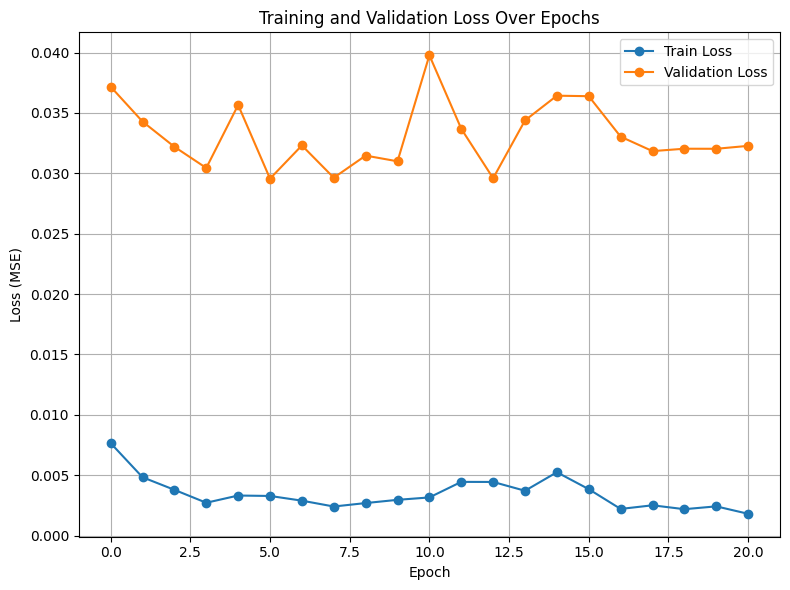

Loss plot saved to c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\plots\training_validation_losses_20241203_181251.png


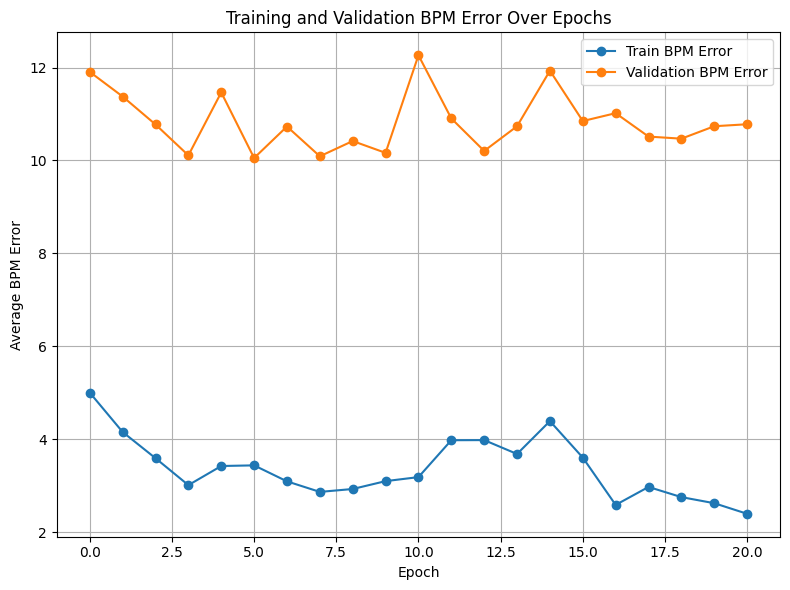

BPM error plot saved to c:\Users\parke\OneDrive\Documents\GitHub\beat_teller_project\plots\training_validation_bpm_errors_20241203_181251.png


In [ ]:
# Create directories for plots if they don't exist
plt_dir = os.path.join(os.getcwd(), 'plots')
os.makedirs(plt_dir, exist_ok=True)

# Generate epochs range
epochs_range = list(range(len(train_losses)))

# Plot Training and Validation Loss in a separate figure
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Validation Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
#plt.ylim([0, max(train_losses + val_losses) * .021])  # Adjust as needed
# Optionally use logarithmic scale
# plt.yscale('log')
plt.tight_layout()
now = datetime.now()
dt_string = now.strftime("%Y%m%d_%H%M%S")
loss_plot_filename = os.path.join(plt_dir, f'training_validation_losses_{dt_string}.png')
plt.savefig(loss_plot_filename)
plt.show()

print(f"Loss plot saved to {loss_plot_filename}")

# Plot Training and Validation BPM Error in a separate figure
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, train_bpm_errors, label='Train BPM Error', marker='o')
plt.plot(epochs_range, val_bpm_errors, label='Validation BPM Error', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average BPM Error')
plt.title('Training and Validation BPM Error Over Epochs')
plt.legend()
plt.grid(True)
# Adjust y-axis limits based on BPM error values
#plt.ylim([0, max(train_bpm_errors + val_bpm_errors) * .2])
plt.tight_layout()
bpm_error_plot_filename = os.path.join(plt_dir, f'training_validation_bpm_errors_{dt_string}.png')
plt.savefig(bpm_error_plot_filename)
plt.show()

print(f"BPM error plot saved to {bpm_error_plot_filename}")